In [1]:
import os
import random
import numpy as np
import cv2
from sklearn.neighbors import KNeighborsClassifier
import re
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

In [2]:
class DataManager:
    def __init__(self, data_path: str, n_samples: int = 2000):
        self.data_path = data_path
        self.n_samples = n_samples
        self.classes = self._get_classes()
        self.images = self._load_images()
        
    def _get_classes(self) -> List[str]:
        """Получение списка классов (символов) из директории данных"""
        return [d for d in os.listdir(self.data_path) if os.path.isdir(os.path.join(self.data_path, d))]
    
    def _load_images(self) -> Dict[str, List[np.ndarray]]:
        """Загрузка изображений для каждого класса"""
        images = {}
        for class_name in self.classes:
            class_path = os.path.join(self.data_path, class_name)
            images[class_name] = []
            pbar = tqdm(os.listdir(class_path)[:self.n_samples])
            pbar.set_description(f"Loading {class_name} images")
            images[class_name] = [cv2.imread(os.path.join(class_path, img_name), cv2.IMREAD_GRAYSCALE) 
                                for img_name in pbar]
        return images
    
    def get_random_image(self, class_name: str) -> np.ndarray:
        """Получение случайного изображения для заданного класса"""
        return random.choice(self.images[class_name])
    
    def get_training_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """Подготовка обучающих данных"""
        X = []
        y = []
        
        for class_name, class_images in self.images.items():
            images = [img.flatten() for img in class_images]
            X.extend(images)
            y.extend([class_name] * len(images))
        
        return np.array(X), np.array(y)

In [3]:
class ExpressionGenerator:
    def __init__(self, data_manager: DataManager):
        self.data_manager = data_manager
        
    def generate_sequence(self) -> Tuple[List[str], List[np.ndarray]]:
        """Генерация последовательности символов и соответствующих изображений"""
        # Генерация структуры выражения
        has_open_bracket = random.choice([True, False])
        has_close_bracket = random.choice([True, False])
        
        sequence = []
        images = []
        
        if has_open_bracket:
            sequence.append('(')
            images.append(self.data_manager.get_random_image('('))
        
        # Первый операнд
        first_operand = random.choice(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'X', 'y'])
        sequence.append(first_operand)
        images.append(self.data_manager.get_random_image(first_operand))
        
        # Операция
        operation = random.choice(['+', '-', 'times'])
        sequence.append(operation)
        images.append(self.data_manager.get_random_image(operation))
        
        # Второй операнд
        second_operand = random.choice(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'X', 'y'])
        sequence.append(second_operand)
        images.append(self.data_manager.get_random_image(second_operand))
        
        if has_close_bracket:
            sequence.append(')')
            images.append(self.data_manager.get_random_image(')'))
            
        return sequence, images

In [4]:
class ExpressionClassifier:
    def __init__(self, data_manager: DataManager):
        self.data_manager = data_manager
        self.classifier = KNeighborsClassifier(n_neighbors=5)
        self.train_data = self.data_manager.get_training_data()
        
    def train(self):
        """Обучение классификатора"""
        X, y = self.train_data
        self.classifier.fit(X, y)
    
    def predict(self, images: List[np.ndarray]) -> List[str]:
        """Предсказание классов для последовательности изображений"""
        X = np.array([img.flatten() for img in images])
        return list(self.classifier.predict(X))

In [28]:
class ExpressionValidator:
    @staticmethod
    def validate_expression(sequence: List[str]) -> bool:
        """Проверка корректности выражения"""
        expr = ''.join(sequence)
        pattern = r'^\(?[0-9xy]([+\-]|times)?[0-9xy]\)?$'
        return bool(re.match(pattern, expr))
    
    @staticmethod
    def evaluate_expression(sequence: List[str], x: float = 0.0, y: float = 0.0) -> float:
        """Вычисление значения выражения"""
        expr = ''.join(sequence)
        expr = expr.replace('times', '*')
        
        if x is not None:
            expr = expr.replace('x', str(x))
        if y is not None:
            expr = expr.replace('y', str(y))
            
        return eval(expr)

In [6]:
class ImageEncoder:
    def __init__(self, patch_size: int = 8):
        self.patch_size = patch_size
        
    def encode_image(self, image: np.ndarray) -> str:
        """Кодирование изображения в бинарную строку"""
        height, width = image.shape
        patches_h = height // self.patch_size
        patches_w = width // self.patch_size
        
        encoded = []
        for i in range(patches_h):
            for j in range(patches_w):
                patch = image[i*self.patch_size:(i+1)*self.patch_size, 
                            j*self.patch_size:(j+1)*self.patch_size]
                # Если в патче есть хотя бы один ненулевой пиксель
                encoded.append('1' if np.any(patch == 0) else '0')
                
        return ''.join(encoded)
    
    def count_isolated_cells(self, encoded: str) -> int:
        """Подсчет количества изолированных клеток"""
        pattern = r'010'
        return len(re.findall(pattern, encoded))
    
    def visualize_isolated_cells(self, image: np.ndarray, encoded: str) -> np.ndarray:
        """Визуализация изолированных клеток на изображении"""
        height, width = image.shape
        patches_h = height // self.patch_size
        patches_w = width // self.patch_size
        
        # Создаем цветное изображение для визуализации
        # vis_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        vis_image = image.copy()
        
        # Находим все изолированные клетки
        isolated_indices = []
        for match in re.finditer(r'010', encoded):
            isolated_indices.append(match.start() + 1)  # +1 потому что нам нужна средняя клетка
        
        # Выделяем изолированные клетки
        for idx in isolated_indices:
            i = idx // patches_w
            j = idx % patches_w
            
            # Рисуем прямоугольник вокруг изолированной клетки
            pt1 = (j * self.patch_size, i * self.patch_size)
            pt2 = ((j + 1) * self.patch_size, (i + 1) * self.patch_size)
            cv2.rectangle(vis_image, pt1, pt2, (128,), 1)
        
        return vis_image

In [7]:
data_path = "dataset"

# Создаем общий менеджер данных
data_manager = DataManager(data_path, n_samples=-1)

# Инициализируем компоненты с общим менеджером данных
generator = ExpressionGenerator(data_manager)
classifier = ExpressionClassifier(data_manager)
validator = ExpressionValidator()
encoder = ImageEncoder()

Loading y images: 100%|██████████| 9339/9339 [00:00<00:00, 11861.47it/s]


In [31]:
sequence, images = generator.generate_sequence()
print("Сгенерированная последовательность:", sequence)

classifier.train()
predicted = classifier.predict(images)
print("Предсказанные символы:", predicted)

if validator.validate_expression(predicted):
    print("Выражение корректно")
    # Вычисление для разных значений x и y
    for x in np.linspace(0, 1, 5):
        for y in np.linspace(0, 1, 5):
            result = validator.evaluate_expression(predicted, x, y)
            print(f"x={x:.2f}, y={y:.2f}: {result:.2f}")
else:
    print("Выражение некорректно")

Сгенерированная последовательность: ['(', '9', 'times', 'y', ')']
Предсказанные символы: ['(', '3', 'times', 'y', ')']
Выражение корректно
x=0.00, y=0.00: 0.00
x=0.00, y=0.25: 0.75
x=0.00, y=0.50: 1.50
x=0.00, y=0.75: 2.25
x=0.00, y=1.00: 3.00
x=0.25, y=0.00: 0.00
x=0.25, y=0.25: 0.75
x=0.25, y=0.50: 1.50
x=0.25, y=0.75: 2.25
x=0.25, y=1.00: 3.00
x=0.50, y=0.00: 0.00
x=0.50, y=0.25: 0.75
x=0.50, y=0.50: 1.50
x=0.50, y=0.75: 2.25
x=0.50, y=1.00: 3.00
x=0.75, y=0.00: 0.00
x=0.75, y=0.25: 0.75
x=0.75, y=0.50: 1.50
x=0.75, y=0.75: 2.25
x=0.75, y=1.00: 3.00
x=1.00, y=0.00: 0.00
x=1.00, y=0.25: 0.75
x=1.00, y=0.50: 1.50
x=1.00, y=0.75: 2.25
x=1.00, y=1.00: 3.00


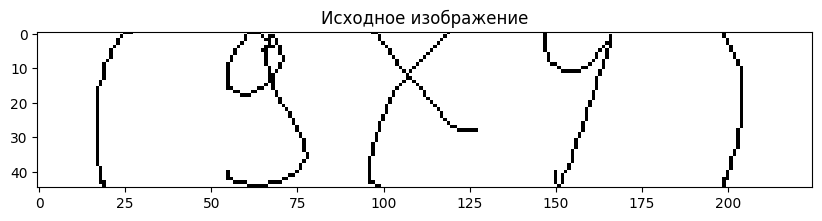

In [32]:
# Treshold
image = np.concatenate(images, axis=1)
image = np.where(image > 128, 255, 0)

# Визуализация исходного изображения
plt.figure(figsize=(10, 5))
plt.imshow(image, cmap='gray')
plt.title('Исходное изображение')
plt.show()


Количество изолированных клеток: 17


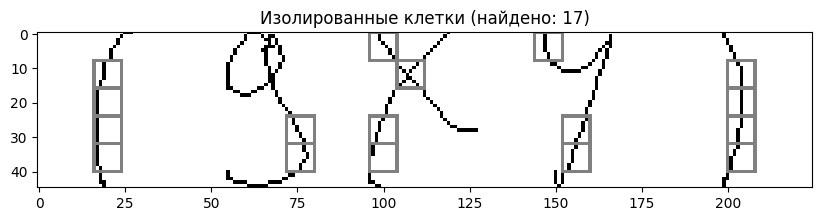

In [33]:
# Кодирование и визуализация изолированных клеток
encoded = encoder.encode_image(image)
isolated_cells = encoder.count_isolated_cells(encoded)
print("\nКоличество изолированных клеток:", isolated_cells)

# Визуализация изолированных клеток
vis_image = encoder.visualize_isolated_cells(image, encoded)

plt.figure(figsize=(10, 5))
plt.imshow(vis_image, cmap='gray')
plt.title(f'Изолированные клетки (найдено: {isolated_cells})')
plt.show()